# Caso Práctico: DBSCAN

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
from sklearn.metrics import homogeneity_score
import numpy as np
import pandas as pd
from sklearn import utils

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


from sklearn.preprocessing import normalize
from collections import Counter
from sklearn.model_selection import ParameterGrid
from sklearn import preprocessing
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

## Funciones auxiliares

In [2]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [3]:
import metricas
from sklearn import metrics
import psutil
#import GPUtil
import time

start_time = time.time()
psutil.cpu_times()
psutil.virtual_memory()
psutil.disk_partitions()

t_cpu = psutil.cpu_times()
cpu_usage = psutil.cpu_percent(1)
mem_usage = psutil.virtual_memory().percent
disco2 = psutil.disk_usage('/')

In [4]:
import os
import psutil
import time
import datetime

def cpu_info():
    cpu = psutil.Process(os.getpid()).cpu_percent (1) # tasa de uso de CPU en un segundo, unidad
    cpu_per = '% .2f %%'% cpu # se convierte en un porcentaje, mantenga dos decimales
    return (cpu_per , cpu)

def mem_info():
    mem = psutil.Process(os.getpid()).memory_percent()
    
    mem_per = '%.2f%%' % mem
    return (mem_per , mem)


def disk_info() :
    c_info = psutil.disk_usage('/')
    c_per = '%.2f%%' % c_info[3]
    return c_per


def medida_tiempo() :
    tiempo = datetime.datetime.now()
    return tiempo


def tiempo_total(t1 , t2) :
    t_total = t2 - t1
    return t_total


def children_process(cpu , mem) :
    c_list= []
    children_list = psutil.Process(os.getpid()).children()
    if len(children_list) > 0:
        for i in range( len (children_list) ):
            c_list += [children_list[ i ].pid]
        info_children = add_children(c_list , cpu , mem)
        return info_children
    else:
        return 'Not children'
    


def add_children(c_list , cpu , mem) :
    cpu_su = cpu[1]
    mem_su = mem[1]
    for i in range( len (c_list)):
        pid = c_list[i]
        cpu_child = psutil.Process(pid).cpu_percent (1)
        mem_child = psutil.Process( pid ).memory_percent()
#         print( cpu_child , mem_child )
        cpu_su += cpu_child
        mem_su += mem_child
    cpu_total = '%.2f%%' % cpu_su
    mem_total = '%.2f%%' % mem_su
    return (cpu_total , mem_total)   

def print_info(cpu , mem , disco , t , otro) :
    if otro == 'Not children':
        var_prin = f'cpu: {cpu[0]}, memoria: {mem[0]}, disco: {disco}, tiempo: {t}'
    if otro != 'Not children':
        var_prin = f'cpu: {otro[0]}, memoria: {otro[1]}, disco: {disco}, tiempo: {t}'
    return var_prin

if __name__ == '__main__' :
    t1 = medida_tiempo()
    cpu = cpu_info()
    mem = mem_info()
    disco = disk_info()
    otro = children_process(cpu , mem)
    t2 = medida_tiempo()
    t= tiempo_total(t1, t2)
    print_info(cpu , mem , disco , t , otro)

## 1. Lectura del conjunto de datos

In [5]:
dfs = []
for i in range(2):
    path = 'Ids_IoT_{}.csv'  # There are 4 input csv files
    #dfs.append(pd.read_csv(path.format(i), usecols=features_to_keep, sep='\t',decimal='.',low_memory=False))
    dfs.append(pd.read_csv(path.format(i), sep=';',decimal='.',low_memory=False))
df = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df
df =utils.shuffle(df, random_state=64)
df

,second,src,dst,packetcount,src_ratio,dst_ratio,src_duration_ratio,dst_duration_ratio,TotalPacketDuration,TotalPacketLenght,src_packet_ratio,dst_packet_ratio,DioCount,DisCount,DaoCount,OtherMsg,label
1835,166.0,41,42,38,0.622951,0.950820,0.904657,0.998884,0.815994,2432,0.605276,0.923843,0,38,0,76,1
481,134.0,13,0,124,0.712644,0.712644,0.850905,0.850905,0.565002,13027,0.774173,0.774173,0,0,0,658,0
1087,289.0,33,22,24,0.157895,0.157895,0.169652,0.169652,0.084991,1824,0.135091,0.135091,0,0,24,0,0
1820,161.0,37,32,6,1.000000,1.000000,1.000000,1.000000,0.002991,612,1.000000,1.000000,6,0,0,0,1
426,122.0,32,37,21,0.077491,0.077491,0.115724,0.115724,0.106003,1596,0.063308,0.063308,0,0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,267.0,36,27,35,0.152174,0.152174,0.275807,0.275807,0.162994,2660,0.139245,0.139245,0,0,35,0,0
54,68.0,40,28,37,0.107872,0.107872,0.010357,0.010357,0.009995,2812,0.107872,0.107872,0,0,37,0,0
2167,342.0,26,24,6,0.092308,0.092308,0.409719,0.409719,0.388000,456,0.092308,0.092308,0,0,6,0,1
998,263.0,27,42,29,0.138095,0.138095,0.130571,0.130571,0.106934,2813,0.130382,0.130382,29,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2534 entries, 1835 to 2500
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   second               2534 non-null   float64
 1   src                  2534 non-null   int64  
 2   dst                  2534 non-null   int64  
 3   packetcount          2534 non-null   int64  
 4   src_ratio            2534 non-null   float64
 5   dst_ratio            2534 non-null   float64
 6   src_duration_ratio   2534 non-null   float64
 7   dst_duration_ratio   2534 non-null   float64
 8   TotalPacketDuration  2534 non-null   float64
 9   TotalPacketLenght    2534 non-null   int64  
 10  src_packet_ratio     2534 non-null   float64
 11  dst_packet_ratio     2534 non-null   float64
 12  DioCount             2534 non-null   int64  
 13  DisCount             2534 non-null   int64  
 14  DaoCount             2534 non-null   int64  
 15  OtherMsg             2534 non-null 

In [7]:
#df = df.drop('Unnamed: 0', axis=1)

In [8]:
df['label'].value_counts()

0    1494
1    1040
Name: label, dtype: int64

## 2. Visualización del conjunto de datos

In [9]:
df.head(10)

,second,src,dst,packetcount,src_ratio,dst_ratio,src_duration_ratio,dst_duration_ratio,TotalPacketDuration,TotalPacketLenght,src_packet_ratio,dst_packet_ratio,DioCount,DisCount,DaoCount,OtherMsg,label
1835,166.0,41,42,38,0.622951,0.950820,0.904657,0.998884,0.815994,2432,0.605276,0.923843,0,38,0,76,1
481,134.0,13,0,124,0.712644,0.712644,0.850905,0.850905,0.565002,13027,0.774173,0.774173,0,0,0,658,0
1087,289.0,33,22,24,0.157895,0.157895,0.169652,0.169652,0.084991,1824,0.135091,0.135091,0,0,24,0,0
1820,161.0,37,32,6,1.000000,1.000000,1.000000,1.000000,0.002991,612,1.000000,1.000000,6,0,0,0,1
426,122.0,32,37,21,0.077491,0.077491,0.115724,0.115724,0.106003,1596,0.063308,0.063308,0,0,21,0,0
1621,96.0,27,26,23,0.198276,0.198276,0.022908,0.022908,0.009003,1748,0.197805,0.197805,0,0,23,0,1
770,196.0,35,40,80,0.240240,0.240240,0.359242,0.359242,0.310028,6080,0.219384,0.219384,0,0,80,0,0
719,188.0,38,42,29,0.111969,0.111969,0.130356,0.130356,0.090988,2813,0.138619,0.138619,29,0,0,0,0
1566,75.0,27,26,23,0.155405,0.155405,0.129071,0.129071,0.098999,1748,0.155405,0.155405,0,0,23,0,1
2327,453.0,24,25,6,1.000000,1.000000,1.000000,1.000000,0.005981,612,1.000000,1.000000,6,0,0,0,1


In [10]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 17
Longitud del conjunto de datos: 2534


In [11]:
# El conjunto de datos se encuntra desequilabrado
df["label"].value_counts()

0    1494
1    1040
Name: label, dtype: int64

In [12]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

second                 False
src                    False
dst                    False
packetcount            False
src_ratio              False
dst_ratio              False
src_duration_ratio     False
dst_duration_ratio     False
TotalPacketDuration    False
TotalPacketLenght      False
src_packet_ratio       False
dst_packet_ratio       False
DioCount               False
DisCount               False
DaoCount               False
OtherMsg               False
label                  False
dtype: bool

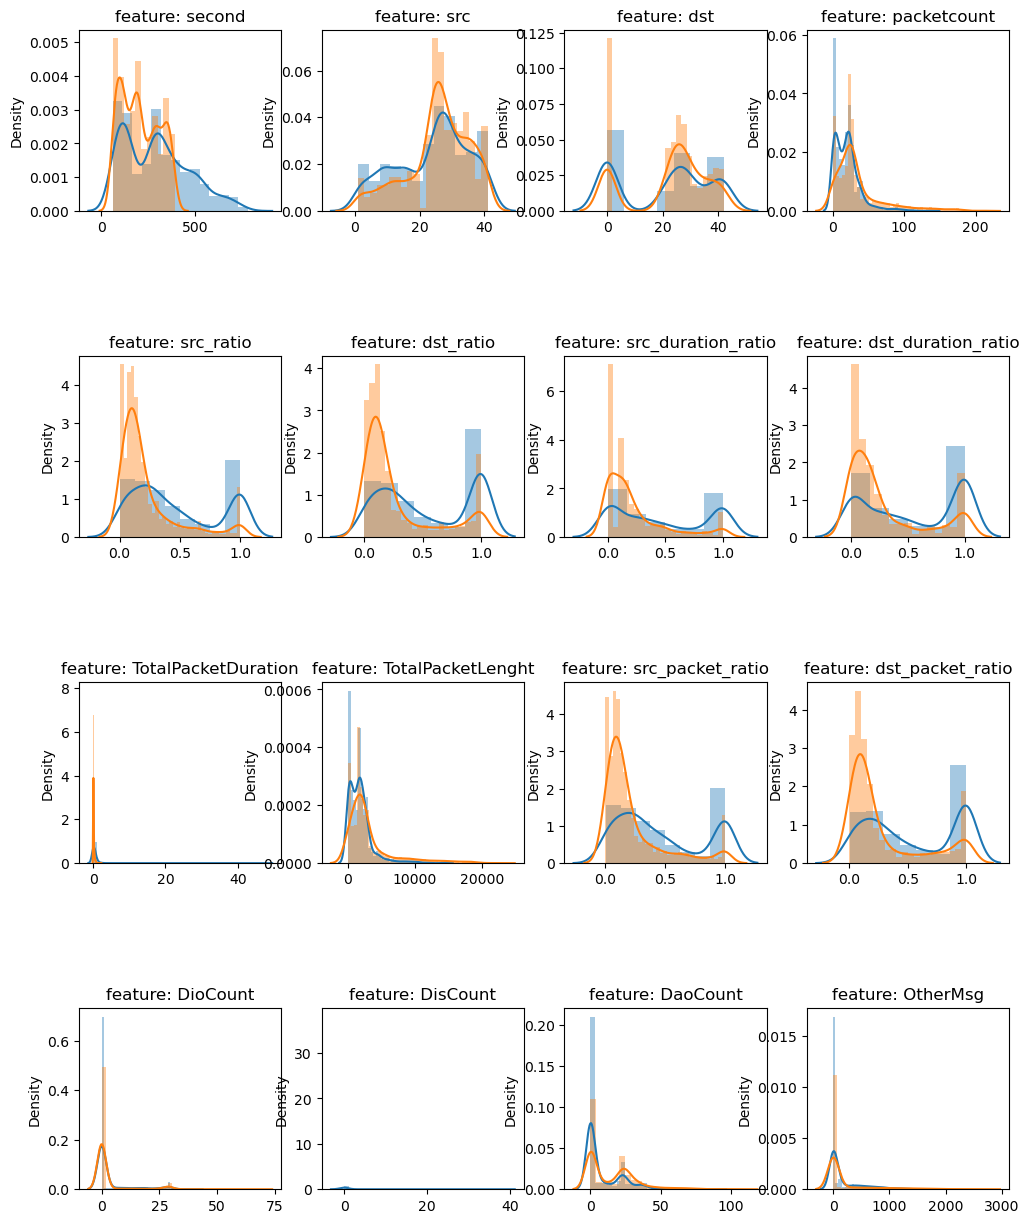

In [13]:
# Representamos gráficamente las características con una medidad de densidad
features = df.drop("label", axis=1)

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f][df["label"] == 1])
    sns.distplot(df[f][df["label"] == 0])
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

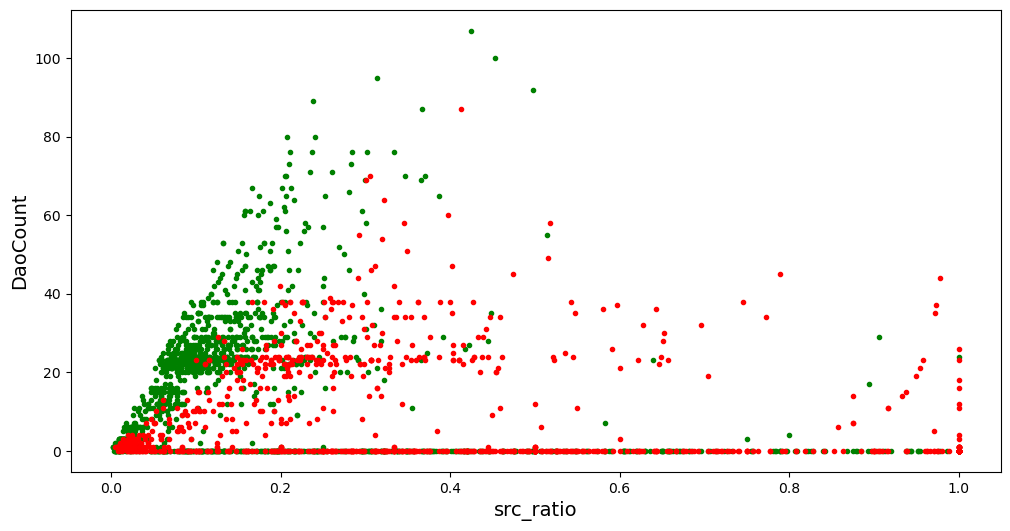

In [14]:
# Escomo algo de explicabilidad con Representación gráfica de dos características que identifican transacciones
#fraudelentas de las legitimas
plt.figure(figsize=(12, 6))
plt.scatter(df["src_ratio"][df['label'] == 0], df["DaoCount"][df['label'] == 0], c="g", marker=".")
plt.scatter(df["src_ratio"][df['label'] == 1], df["DaoCount"][df['label'] == 1], c="r", marker=".")
plt.xlabel("src_ratio", fontsize=14)
plt.ylabel("DaoCount", fontsize=14)
plt.show()

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [15]:
#estan en escalas diferentes a las demas atributos
df = df.drop(["second", "src", "dst"], axis=1)

In [16]:
df.columns

Index(['packetcount', 'src_ratio', 'dst_ratio', 'src_duration_ratio',
       'dst_duration_ratio', 'TotalPacketDuration', 'TotalPacketLenght',
       'src_packet_ratio', 'dst_packet_ratio', 'DioCount', 'DisCount',
       'DaoCount', 'OtherMsg', 'label'],
      dtype='object')

## 4. DBSCAN con un conjunto de datos de dos dimensiones

Antes de comenzar con el entrenamiento de DBSCAN para todos los atributos del conjunto de datos, se realiza una prueba para dos atributos con el objetivo de comprender como construye el límite de decisión.

In [17]:
#Se hace para ver el limite de decision con dos atributos
#Dbscan es de clustering y solo trabajara con X sin la etiqueta y
X = df[['packetcount', 'src_ratio', 'dst_ratio', 'src_duration_ratio',
       'dst_duration_ratio', 'TotalPacketDuration', 'TotalPacketLenght',
       'src_packet_ratio', 'dst_packet_ratio', 'DioCount', 'DisCount',
       'DaoCount', 'OtherMsg']].copy()
y = df["label"].copy()

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=13)#samples controla el # de clusters a generar
dbscan.fit(df)

DBSCAN(eps=0.15, min_samples=13)

In [19]:
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker=".", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

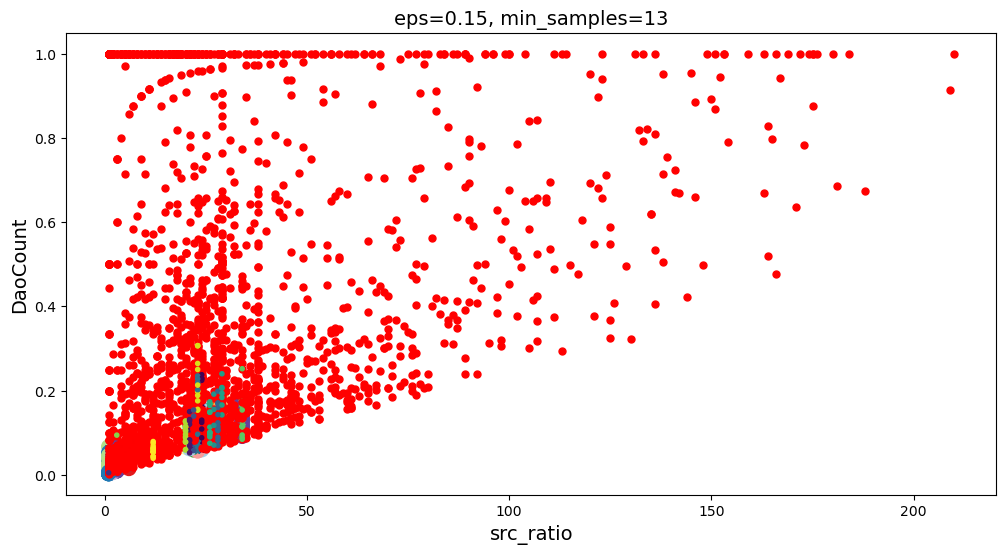

In [20]:
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X.values, size=100)
plt.xlabel("src_ratio", fontsize=14)
plt.ylabel("DaoCount", fontsize=14)
plt.show()

In [21]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label -1 has 1965 samples - 973 are malicious samples
Label 0 has 72 samples - 0 are malicious samples
Label 1 has 33 samples - 0 are malicious samples
Label 2 has 72 samples - 0 are malicious samples
Label 3 has 53 samples - 53 are malicious samples
Label 4 has 32 samples - 0 are malicious samples
Label 5 has 16 samples - 0 are malicious samples
Label 6 has 84 samples - 0 are malicious samples
Label 7 has 20 samples - 0 are malicious samples
Label 8 has 19 samples - 0 are malicious samples
Label 9 has 25 samples - 0 are malicious samples
Label 10 has 15 samples - 0 are malicious samples
Label 11 has 21 samples - 0 are malicious samples
Label 12 has 26 samples - 0 are malicious samples
Label 13 has 31 samples - 0 are malicious samples
Label 14 has 21 samples - 0 are malicious samples
Label 15 has 14 samples - 14 are malicious samples
Label 16 has 15 samples - 0 are malicious samples


- label -1 son ejemplo de ruido y han quedado 1837 ejemplo malaicioos¿¿sos como de ruido, se considera este ruido como un cluster el -1
- la intuicion es que el ejmplo de rudo es intersante para analixzar que pasas ahi, es analizar los 3612 casi se ve toda las transacciones fraaudulentas. En esta caso analizar los noise point. Mejores resulatdos.

## 5. Reducción del número de características

In [22]:
X = df.drop("label", axis=1)
y = df["label"].copy()

### Aplicamos selección de características con _Random Forest_

In [23]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [24]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(df), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

In [25]:
# Reducimos el conjunto de datos a las 7 características más importantes
X_reduced = X[list(feature_importances_sorted.head(7).index)].copy()

In [26]:
X_reduced

,TotalPacketDuration,TotalPacketLenght,packetcount,src_packet_ratio,src_ratio,dst_packet_ratio,src_duration_ratio
1835,0.815994,2432,38,0.605276,0.622951,0.923843,0.904657
481,0.565002,13027,124,0.774173,0.712644,0.774173,0.850905
1087,0.084991,1824,24,0.135091,0.157895,0.135091,0.169652
1820,0.002991,612,6,1.000000,1.000000,1.000000,1.000000
426,0.106003,1596,21,0.063308,0.077491,0.063308,0.115724
...,...,...,...,...,...,...,...
1009,0.162994,2660,35,0.139245,0.152174,0.139245,0.275807
54,0.009995,2812,37,0.107872,0.107872,0.107872,0.010357
2167,0.388000,456,6,0.092308,0.092308,0.092308,0.409719
998,0.106934,2813,29,0.130382,0.138095,0.130382,0.130571


In [27]:
#Escala de los datos
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X_reduced).transform(X_reduced)

In [28]:
X_normalized = normalize(ss)

In [29]:
df1 = pd.DataFrame(X_normalized)
df1.columns = X_reduced.columns
df1.head(10)

,TotalPacketDuration,TotalPacketLenght,packetcount,src_packet_ratio,src_ratio,dst_packet_ratio,src_duration_ratio
0,0.185350,-0.023525,0.118651,0.337543,0.362078,0.547978,0.636945
1,0.050581,0.626653,0.600143,0.265977,0.232187,0.195134,0.286083
2,-0.127537,-0.219480,-0.133892,-0.493814,-0.436603,-0.587461,-0.371551
3,-0.054113,-0.158224,-0.186257,0.519667,0.524697,0.404080,0.478230
4,-0.082102,-0.206888,-0.161274,-0.502748,-0.479106,-0.552633,-0.369792
5,-0.178523,-0.232973,-0.157566,-0.316709,-0.317968,-0.429240,-0.709487
6,0.021939,0.518008,0.804198,-0.147316,-0.117714,-0.215066,0.051384
7,-0.116240,0.048599,0.008740,-0.457529,-0.529070,-0.547171,-0.442048
8,-0.116990,-0.240068,-0.162364,-0.439248,-0.442873,-0.540061,-0.470720
9,-0.053476,-0.158230,-0.186263,0.519685,0.524715,0.404094,0.478246


### Entrenamiento de DBSCAN con el conjunto de datos reducido
- inicio a 11:46 - termina a las 11:53

In [30]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.70, min_samples=25)
dbscan.fit(X_reduced)

DBSCAN(eps=0.7, min_samples=25)

In [31]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label -1 has 1423 samples - 688 are malicious samples
Label 0 has 111 samples - 36 are malicious samples
Label 1 has 48 samples - 9 are malicious samples
Label 2 has 134 samples - 42 are malicious samples
Label 3 has 97 samples - 37 are malicious samples
Label 4 has 25 samples - 3 are malicious samples
Label 5 has 154 samples - 71 are malicious samples
Label 6 has 38 samples - 12 are malicious samples
Label 7 has 27 samples - 5 are malicious samples
Label 8 has 36 samples - 5 are malicious samples
Label 9 has 26 samples - 7 are malicious samples
Label 10 has 72 samples - 28 are malicious samples
Label 11 has 37 samples - 8 are malicious samples
Label 12 has 35 samples - 5 are malicious samples
Label 13 has 41 samples - 10 are malicious samples
Label 14 has 56 samples - 16 are malicious samples
Label 15 has 42 samples - 23 are malicious samples
Label 16 has 43 samples - 12 are malicious samples
Label 17 has 46 samples - 5 are malicious samples
Label 18 has 43 samples - 18 are malicious 

## 6. Evaluación de los resultados

Hay que tener cuidado con los conjuntos de datos desequilibrados cuando se utilizan métricas para medir la pureza de los clusters. Una posible solución es utilizar técnicas de equilibrado del conjunto de datos, como la generación de más ejemplos de transacciones fraudulentas o la disminución de ejemplos de transacciones legítimas.

In [32]:
# Obtenemos los clusters del objeto dbscan
clusters = dbscan.labels_

In [33]:
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
# no es bueno para evaluarv data desequilbrada hay muchos datos puros.
print("Purity Score:", purity_score(y, clusters))

Purity Score: 0.5911602209944752


In [34]:
# Calculamos el coeficiente de Shiloutte, es importante darse cuenta de que no le pasamos las etiquetas
#cuando se acreca a cero los clustres estan superpuestos es mal.

print("Shiloutte: ", metrics.silhouette_score(df1, clusters))

Shiloutte:  -0.2191253553702792


In [35]:
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
#Bueno para conparar entre algortimos y es de 913
print("Calinski harabasz: ", metrics.calinski_harabasz_score(df1, clusters))

Calinski harabasz:  45.03952544621498


In [36]:
print('Evaluación de los resultados_Metricas de Clustering LOF')
print('############################################################')
# Calculamos el purity score, es importante darse cuenta de que recibe las etiquetas
# no es bueno para evaluarv data desequilbrada hay muchos datos puros.Una sola pasada.
print("Purity Score: %0.3f"% purity_score(y, clusters))
print("V-measure: %0.3f" % metrics.v_measure_score(y, clusters))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, clusters))
#cada grupo contiene solo miembros de una sola clase.
# esta delimitado por debajo de 0.0 y por encima de 1.0 (cuanto más alto, mejor):
#se atribuirá más peso a la homogeneidad, y utilizando un valor superior a 1:
print("Completeness: %0.3f" % metrics.completeness_score(y, clusters))

print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, clusters))

print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(y, clusters))

# Calculamos el coeficiente de Silueta, es importante darse cuenta de que no le pasamos las etiquetas
#cuando se acerca a cero los clustres estan superpuestos es mal.(demora 10'), mejor qitar el size de 1000 más real
print("Shiloutte:  %0.3f" % metrics.silhouette_score(df1, clusters,sample_size=10000))

from sklearn.metrics import davies_bouldin_score
print("davies_bouldin_score:  %0.3f" % davies_bouldin_score(df1, clusters))
# Calculamos el Calinski harabasz score, es importante darse cuenta de que no le pasamos las etiquetas
#Bueno para conparar entre algortimos y es de 913 (Una sola pasada).
print("Calinski harabasz: %0.3f" % metrics.calinski_harabasz_score(df1, clusters))

Evaluación de los resultados_Metricas de Clustering LOF
############################################################
Purity Score: 0.591
V-measure: 0.021
Homogeneity: 0.041
Completeness: 0.014
Adjusted Rand Index: -0.017
Adjusted Mutual Information: 0.018
Shiloutte:  -0.219
davies_bouldin_score:  10.081
Calinski harabasz: 45.040


## 7. Estrop ejemplo Problemas típicos que pueden resolverse con DBSCAN y no k-means

DBSCAN es útil para solucionar problemas como el que se plantea a continuación.

In [37]:
# Generamos un conjunto de datos
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

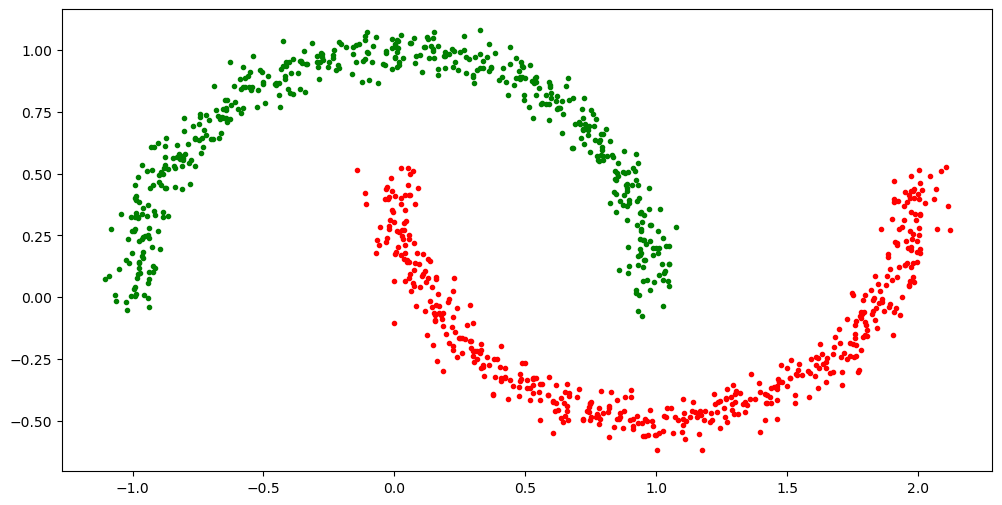

In [38]:
plt.figure(figsize=(12, 6))
plt.scatter(X[:,0][y == 0], X[:,1][y == 0], c="g", marker=".")
plt.scatter(X[:,0][y == 1], X[:,1][y == 1], c="r", marker=".")
plt.show()

In [39]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.1, min_samples=6)
dbscan.fit(X)

DBSCAN(eps=0.1, min_samples=6)

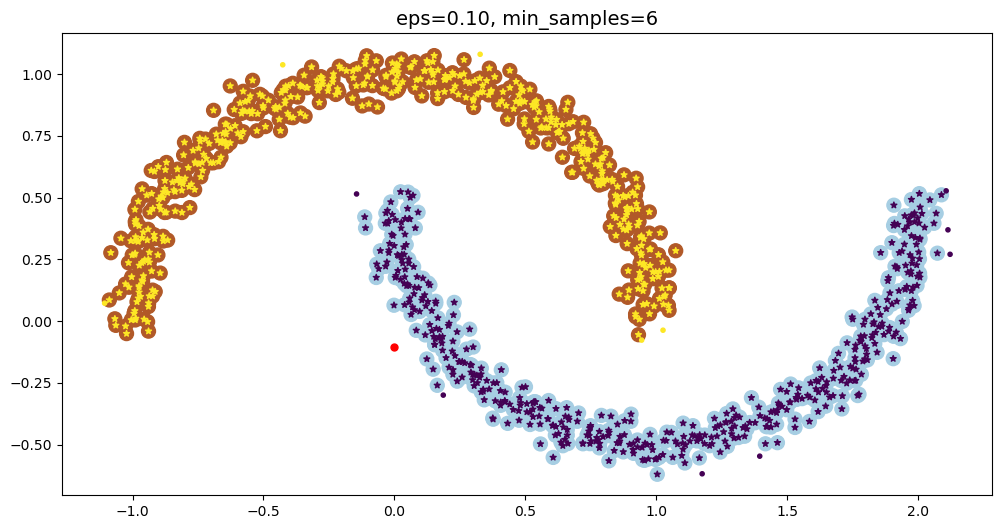

In [40]:
# Representamos el límite de decisión
plt.figure(figsize=(12, 6))
plot_dbscan(dbscan, X, size=100)
plt.show()

In [41]:
counter = Counter(dbscan.labels_.tolist())
bad_counter = Counter(dbscan.labels_[y == 1].tolist())

for key in sorted(counter.keys()):
    print("Label {0} has {1} samples - {2} are malicious samples".format(
        key, counter[key], bad_counter[key]))

Label -1 has 1 samples - 1 are malicious samples
Label 0 has 499 samples - 499 are malicious samples
Label 1 has 500 samples - 0 are malicious samples
